## Importing libraries

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

In [11]:
# Number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

## Loading Data

In [ ]:
# Load the pre-split training and testing datasets
train_file_path = '../data/data-reduced-train.csv'  # Replace with the actual training data file path
test_file_path = '../data/data-reduced-test.csv'    # Replace with the actual testing data file path

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Define the target variable
target = "% Adults with Diabetes"

# Perform validation splits from the training data for cross-validation
#validation_relative_size = 0.2  # 20% of the training data for validation
#train_subset, val_data = train_test_split(train_data, test_size=validation_relative_size, random_state=42)

#print(f"Train subset size: {len(train_subset)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Train subset size: 2010, Validation size: 503, Test size: 629


## Data Exploration

In [13]:
train_data.columns

Index(['FIPS', 'State', 'County', '% Adults with Diabetes',
       '% Adults Reporting Currently Smoking', '% Adults with Obesity',
       'Food Environment Index', '% Physically Inactive',
       '% With Access to Exercise Opportunities', '% Excessive Drinking',
       '% Driving Deaths with Alcohol Involvement', '% Uninsured',
       'Dentist Rate', '% with Annual Mammogram', '% Vaccinated',
       '% Completed High School', '% Unemployed', '% Children in Poverty',
       'Income Ratio', '% Children in Single-Parent Households',
       'Social Association Rate', 'Average Daily PM2.5',
       '% Severe Housing Problems', '% Drive Alone to Work',
       '% Long Commute - Drives Alone', '% Food Insecure',
       '% Limited Access to Healthy Foods', '% Insufficient Sleep',
       '% Uninsured Children', 'Other Primary Care Provider Rate',
       'School Funding Adequacy', 'Gender Pay Gap', 'Median Household Income',
       '% Household Income Required for Child Care Expenses',
       '% 

In [14]:
train_data.head()

,FIPS,State,County,% Adults with Diabetes,% Adults Reporting Currently Smoking,% Adults with Obesity,Food Environment Index,% Physically Inactive,% With Access to Exercise Opportunities,% Excessive Drinking,...,% 65 and Over,% Black,% American Indian or Alaska Native,% Asian,% Native Hawaiian or Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural
0,17027,Illinois,Clinton,8.7,16.7,34.8,9.0,25.8,63.809317,18.658612,...,18.662115,3.243111,0.403696,0.655667,0.083990,3.541142,91.007613,0.535157,47.787802,80.216266
1,42071,Pennsylvania,Lancaster,8.2,16.7,35.2,8.8,23.4,80.948635,17.168046,...,19.735587,3.722587,0.474823,2.778152,0.114798,11.589407,80.193630,2.150077,50.747266,27.875490
2,46003,South Dakota,Aurora,8.2,17.0,38.8,7.8,23.1,3.349108,21.089477,...,21.125227,0.907441,2.903811,0.943739,0.000000,8.457350,85.880218,1.615576,48.566243,100.000000
3,46027,South Dakota,Clay,9.2,16.3,35.6,7.6,22.2,85.568250,22.062377,...,12.624346,1.760471,4.011780,2.729058,0.065445,3.331152,86.302356,0.406533,50.425393,22.101958
4,13205,Georgia,Mitchell,15.9,22.8,42.2,6.8,34.5,59.917260,13.354151,...,18.407842,45.870430,0.672476,0.975564,0.066300,5.479257,46.126160,0.725704,49.720591,75.775684


## Removal of low correlation features

In [18]:
features = train_data.columns[4:].to_list()

target_and_feature_list = [target] + features
correlations_with_target = train_data[target_and_feature_list].corr().loc[:, target] #column of correlation matrix corresponding to the target
low_correlation_features = [feature for feature in correlations_with_target.index if np.abs(correlations_with_target[feature]) <= 0.3]

train_data = train_data.drop(columns=low_correlation_features)
test_data = test_data.drop(columns=low_correlation_features)

In [20]:
# Perform validation splits from the training data for cross-validation
validation_relative_size = 0.2  # 20% of the training data for validation
train_subset, val_data = train_test_split(train_data, test_size=validation_relative_size, random_state=42)

print(f"Train subset size: {len(train_subset)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

Train subset size: 2010, Validation size: 503, Test size: 629


## Grouping features

In [21]:
%run ../data/features-grouped.ipynb

In [22]:
# Filter out non-numeric features
numeric_columns = train_data.select_dtypes(include=[np.number]).columns

# Initialize the lists with intersection and numeric filtering
health_behaviors_features = [
    feature for feature in features_by_category["Health Behaviors"] 
    if feature in train_data.columns and feature in numeric_columns
]

access_to_care_features = [
    feature for feature in features_by_category["Access to Care"] 
    if feature in train_data.columns and feature in numeric_columns
]

socio_economic_features = [
    feature for feature in features_by_category["Socio-economic Factors"] 
    if feature in train_data.columns and feature in numeric_columns
]

physical_environment_features = [
    feature for feature in features_by_category["Physical Environment"] 
    if feature in train_data.columns and feature in numeric_columns
]

demographics_features = [
    feature for feature in features_by_category["Demographics"] 
    if feature in train_data.columns and feature in numeric_columns
]

# Combine all features into a single list (union of all categories)
all_features = list(
    set(
        health_behaviors_features +
        access_to_care_features +
        socio_economic_features +
        physical_environment_features +
        demographics_features
    )
)

## Modelling and RMSEs

In [ ]:
# Dictionary to store results
results = {}
models = {}

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': np.linspace(0.01, 0.2, 5),
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

# Create a dictionary of feature sets for models
feature_sets = {
    "Model 1 (All Features)": all_features,
    "Model 2 (Health Behaviors)": health_behaviors_features,
    "Model 3 (Access to Care)": access_to_care_features,
    "Model 4 (Socio-economic Factors)": socio_economic_features,
    "Model 5 (Physical Environment)": physical_environment_features,
    "Model 6 (Demographics)": demographics_features
}

# Initialize KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Randomized Search and model evaluation
for feature_set_name, feature_set in feature_sets.items():
    print(f"Tuning hyperparameters for {feature_set_name}...")
    
    fold_rmse = []
    
    # Cross-validation with hyperparameter tuning
    for train_index, val_index in kf.split(train_data):
        # Split into train and validation sets for this fold
        train_fold = train_data.iloc[train_index]
        val_fold = train_data.iloc[val_index]

        X_train_fold = train_fold[feature_set]
        y_train_fold = train_fold[target]
        X_val_fold = val_fold[feature_set]
        y_val_fold = val_fold[target]
        
        # Perform Randomized Search
        model = XGBRegressor(random_state=42)
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=20,  # Limit to 20 combinations
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            random_state=42
        )
        random_search.fit(X_train_fold, y_train_fold)
        
        # Get the best model
        best_model = random_search.best_estimator_
        models[feature_set_name] = best_model
        
        # Predict and calculate RMSE for the validation fold
        y_pred_fold = best_model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        fold_rmse.append(rmse.round(2))
    
    # Evaluate the best model on the entire validation set
    X_val = val_data[feature_set]
    y_val = val_data[target]
    y_pred_val = best_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    # Evaluate the best model on the test set
    #X_test = test_data[feature_set]
    #y_test = test_data[target]
    #y_pred_test = best_model.predict(X_test)
    #test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Store results
    results[feature_set_name] = {
        "Best Parameters": random_search.best_params_,
        "Cross-Validation RMSEs": fold_rmse,
        "Validation RMSE": val_rmse,
        #"Test RMSE": test_rmse
    }

Tuning hyperparameters for Model 1 (All Features)...
Tuning hyperparameters for Model 2 (Health Behaviors)...
Tuning hyperparameters for Model 3 (Access to Care)...
Tuning hyperparameters for Model 4 (Socio-economic Factors)...
Tuning hyperparameters for Model 5 (Physical Environment)...
Tuning hyperparameters for Model 6 (Demographics)...
Results for Model 1 (All Features):
  Best Parameters: {'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': np.float64(0.15250000000000002)}
  Cross-Validation RMSEs: [np.float64(0.53), np.float64(0.51), np.float64(0.54), np.float64(0.47), np.float64(0.51)]
  Validation RMSE: 0.32
Results for Model 2 (Health Behaviors):
  Best Parameters: {'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': np.float64(0.15250000000000002)}
  Cross-Validation RMSEs: [np.float64(1.01), np.float64(1.02), np.float64(1.06), np.float64(0.92), np.float64(0.95)]
  Validation RMSE: 0.78
Results for Mode

In [26]:
# Display the results
for model_name, rmses in results.items():
    print(f"Results for {model_name}:")
    print(f"  Best Parameters: {rmses['Best Parameters']}")
    print(f"  Cross-Validation RMSEs: {rmses['Cross-Validation RMSEs']}")
    print(f"  Validation RMSE: {rmses['Validation RMSE']:.2f}\n")
    #print(f"  Test RMSE: {rmses['Test RMSE']:.2f}\n")

Results for Model 1 (All Features):
  Best Parameters: {'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': np.float64(0.15250000000000002)}
  Cross-Validation RMSEs: [np.float64(0.53), np.float64(0.51), np.float64(0.54), np.float64(0.47), np.float64(0.51)]
  Validation RMSE: 0.32

Results for Model 2 (Health Behaviors):
  Best Parameters: {'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': np.float64(0.15250000000000002)}
  Cross-Validation RMSEs: [np.float64(1.01), np.float64(1.02), np.float64(1.06), np.float64(0.92), np.float64(0.95)]
  Validation RMSE: 0.78

Results for Model 3 (Access to Care):
  Best Parameters: {'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': np.float64(0.2)}
  Cross-Validation RMSEs: [np.float64(1.87), np.float64(1.84), np.float64(1.9), np.float64(1.75), np.float64(1.8)]
  Validation RMSE: 1.74

Results for Model 4 (Socio-economic Factors):
  Best P

## Conclusion: 
### Feature groups in order of importance (low - high RMSE): 
### Socio-economic factors, Health behaviours, Demographics, Physical environment, Access to Care. 

In [24]:
print(all_features)

['% Excessive Drinking', '% Unemployed', '% Black', '% Uninsured', '% Children in Poverty', '% Adults Reporting Currently Smoking', 'Income Ratio', 'Food Environment Index', '% Children in Single-Parent Households', '% Physically Inactive', 'Average Daily PM2.5', '% Severe Housing Problems', 'School Funding Adequacy', '% with Annual Mammogram', '% With Access to Exercise Opportunities', '% Adults with Obesity', '% Food Insecure', '% Completed High School', 'Median Household Income', '% Vaccinated', '% Households with Broadband Access', '% Non-Hispanic White']


## Feature Importance

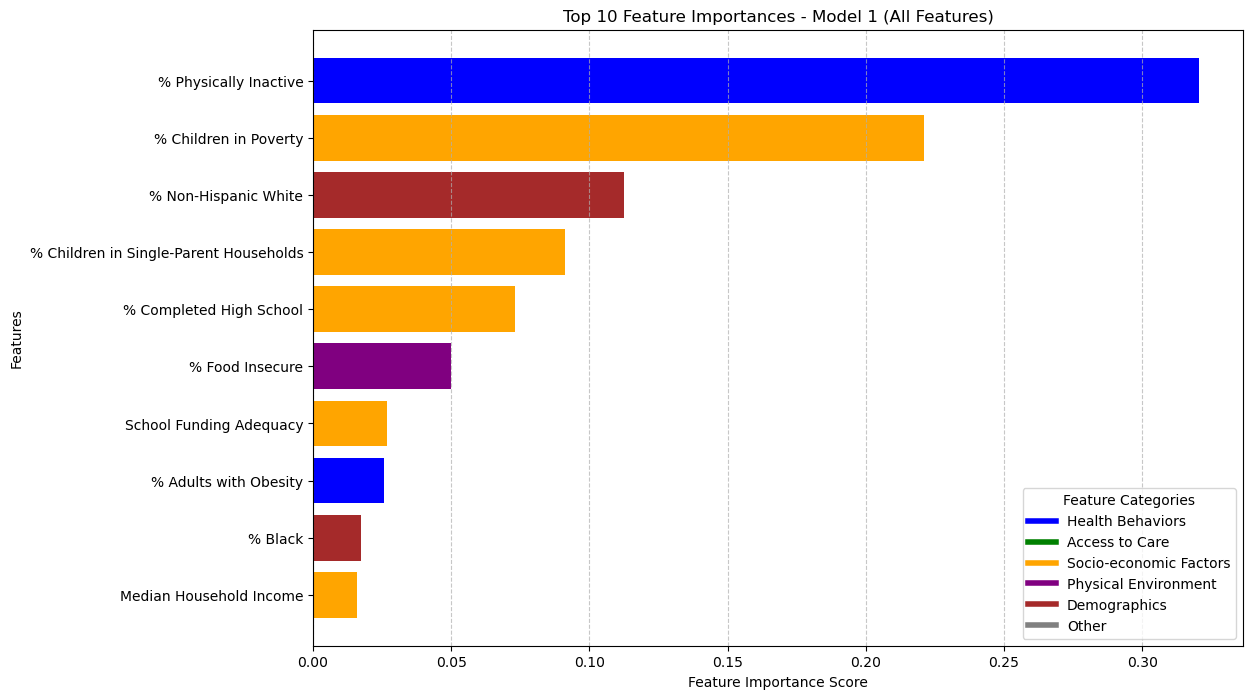

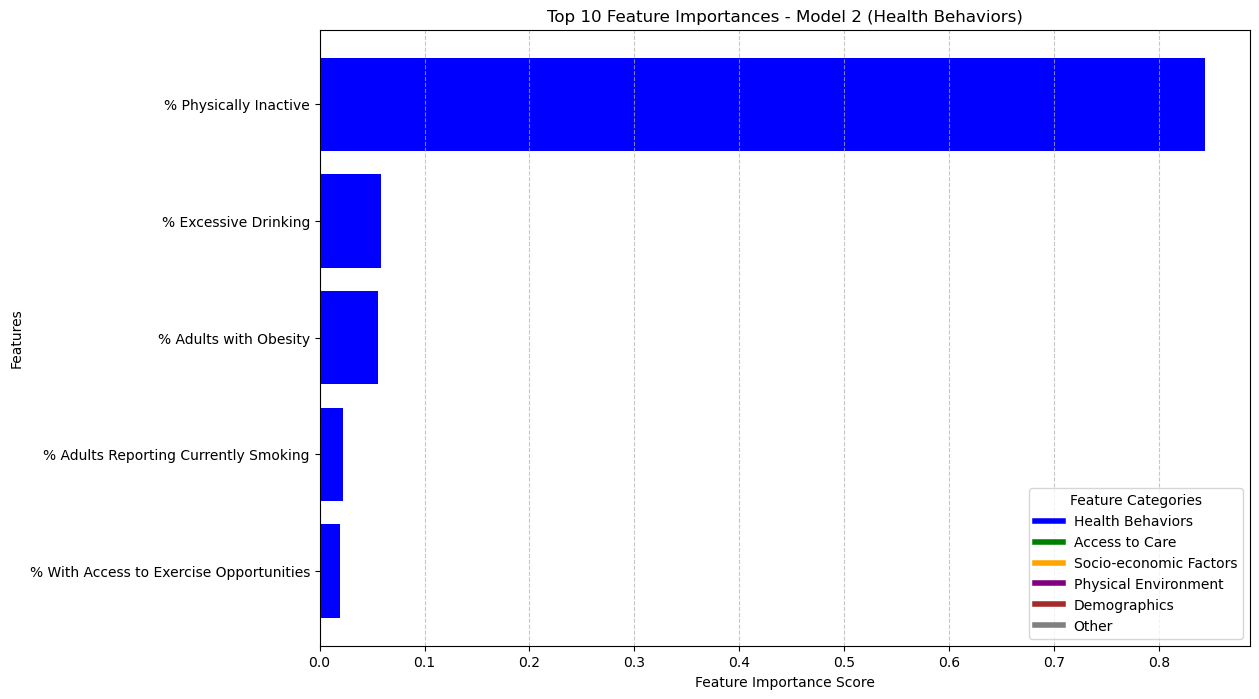

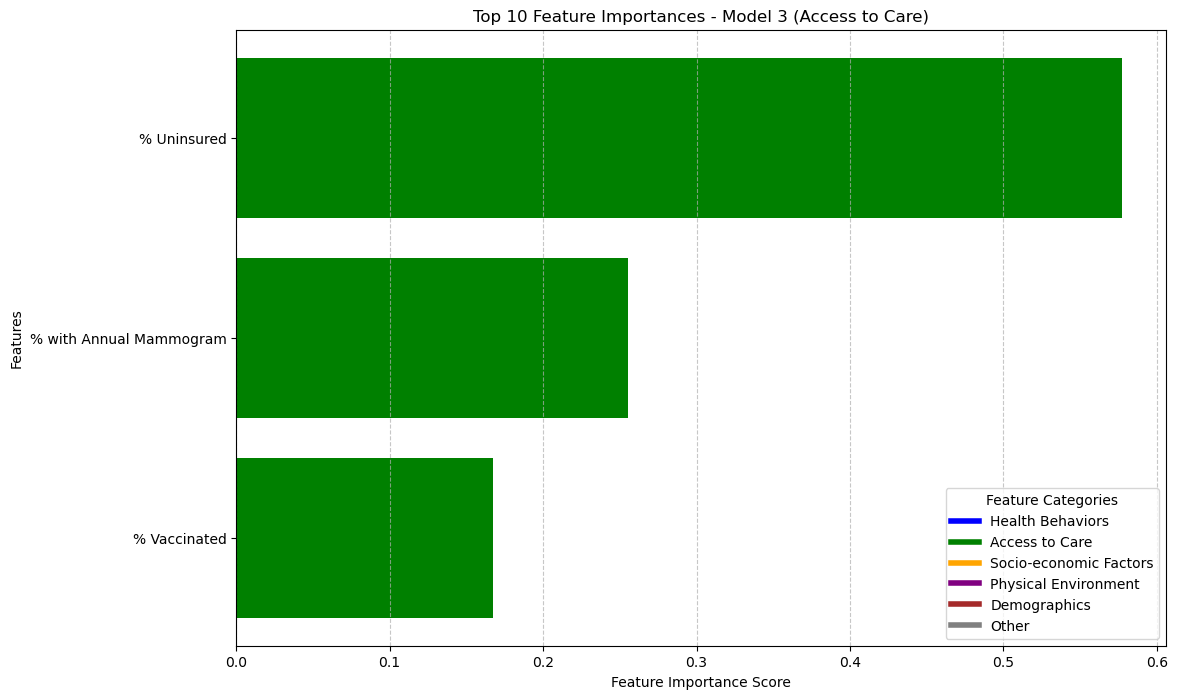

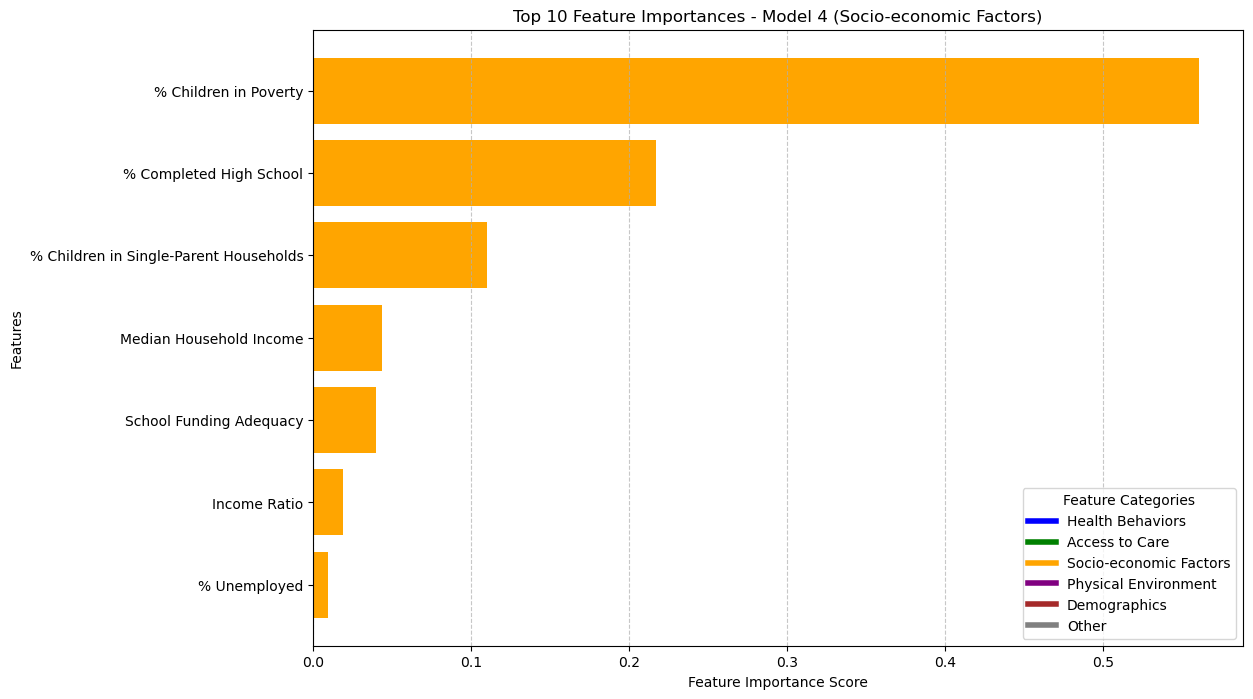

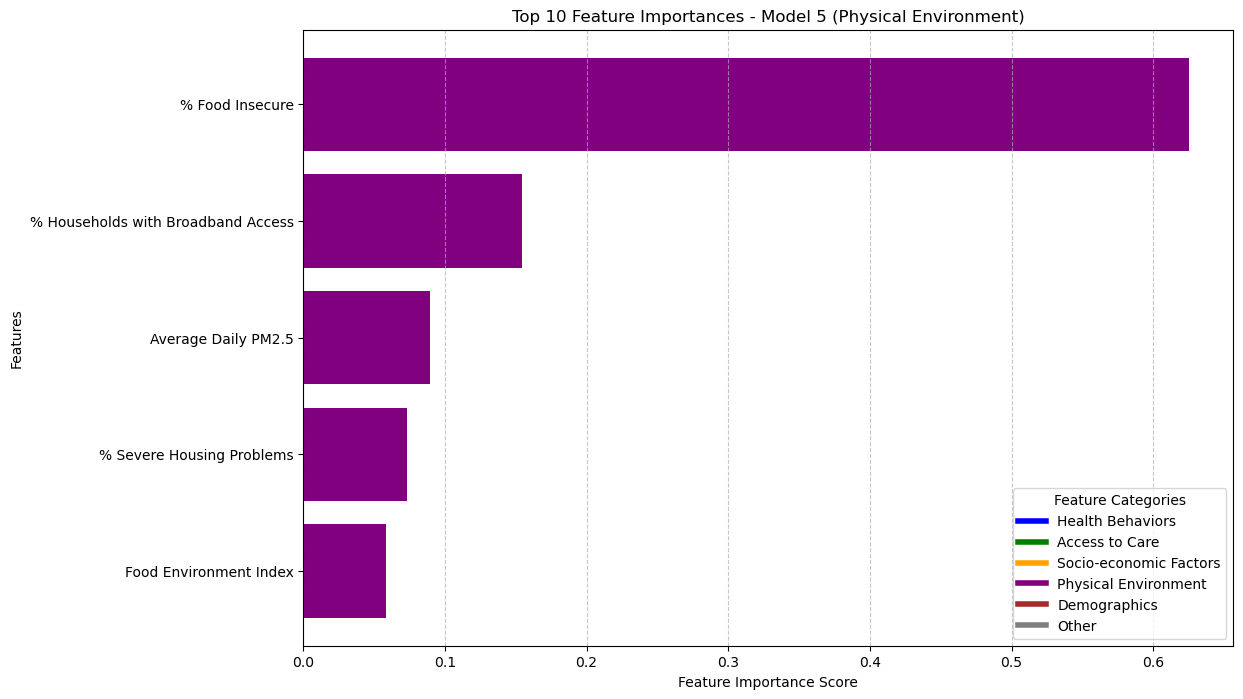

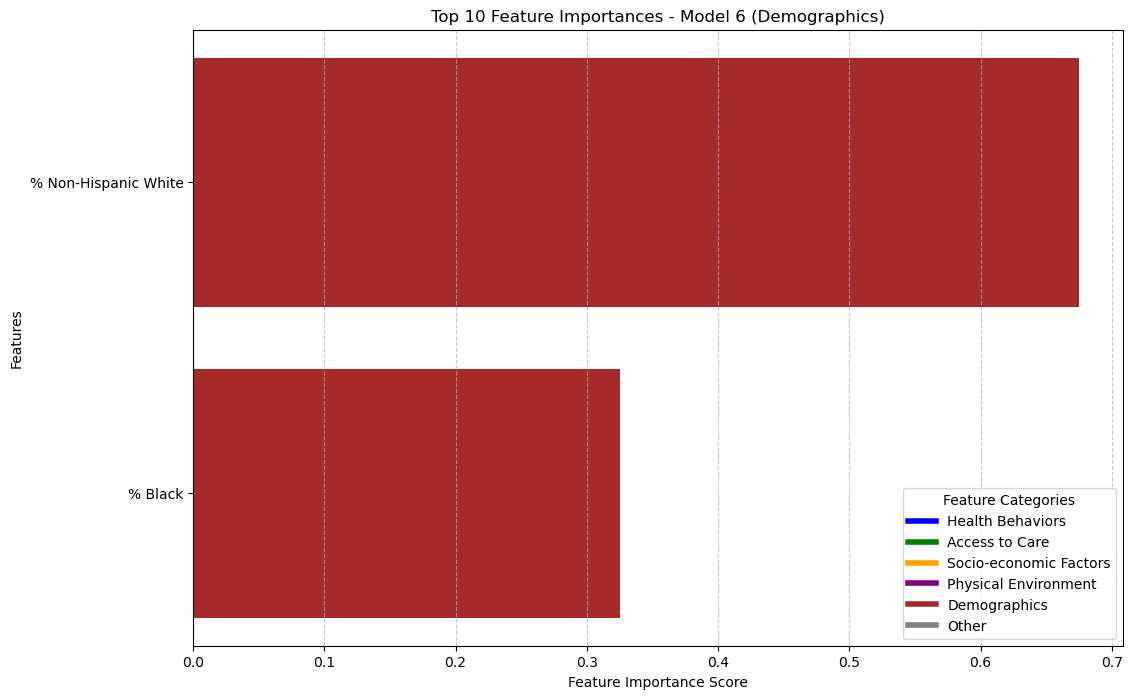

In [25]:
# Define colors for feature categories
category_colors = {
    "Health Behaviors": "blue",
    "Access to Care": "green",
    "Socio-economic Factors": "orange",
    "Physical Environment": "purple",
    "Demographics": "brown",
    "Other": "gray"  # Default color for unmapped features
}

# Mapping features to their categories
feature_categories = {
    **{feature: "Health Behaviors" for feature in health_behaviors_features},
    **{feature: "Access to Care" for feature in access_to_care_features},
    **{feature: "Socio-economic Factors" for feature in socio_economic_features},
    **{feature: "Physical Environment" for feature in physical_environment_features},
    **{feature: "Demographics" for feature in demographics_features}
}

# Plot feature importances for all models
for model_name, model in models.items():
    # Match the feature set to the model
    feature_set = {
        "Model 1 (All Features)": all_features,
        "Model 2 (Health Behaviors)": health_behaviors_features,
        "Model 3 (Access to Care)": access_to_care_features,
        "Model 4 (Socio-economic Factors)": socio_economic_features,
        "Model 5 (Physical Environment)": physical_environment_features,
        "Model 6 (Demographics)": demographics_features
    }[model_name]
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_features = [feature_set[i] for i in indices]
    sorted_importances = importances[indices]

    # Assign colors to the features
    sorted_colors = [
        category_colors.get(feature_categories.get(feature, "Other"), "gray")
        for feature in sorted_features
    ]

    # Plot top 10 feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(sorted_features[:10], sorted_importances[:10], align='center', color=sorted_colors[:10])
    plt.title(f"Top 10 Feature Importances - {model_name}")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=4, label=label) 
                        for label, color in category_colors.items()],
               title="Feature Categories")
    plt.show()


## Residual Plots and Sample Predictions

Residual Analysis and Sample Predictions for Model 1 (All Features):


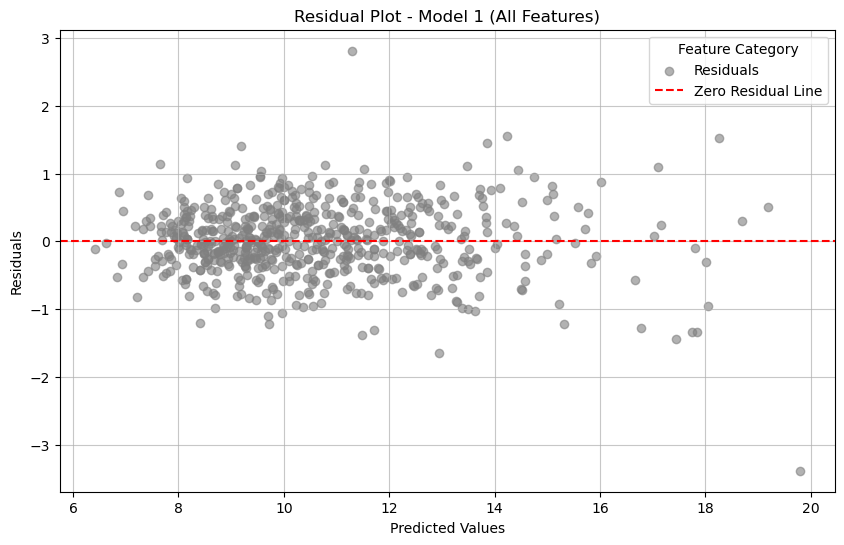

Sample Predictions:
         County         State  % Adults with Diabetes  Predicted  Residual
350       Pasco       Florida                     9.9       10.3      -0.4
590  Rensselaer      New York                     9.1        9.1       0.0
107     Webster          Iowa                     9.3        9.5      -0.2
32     Burleigh  North Dakota                     7.9        7.7       0.2
232  Rockingham      Virginia                     9.4        9.0       0.4


Residual Analysis and Sample Predictions for Model 2 (Health Behaviors):


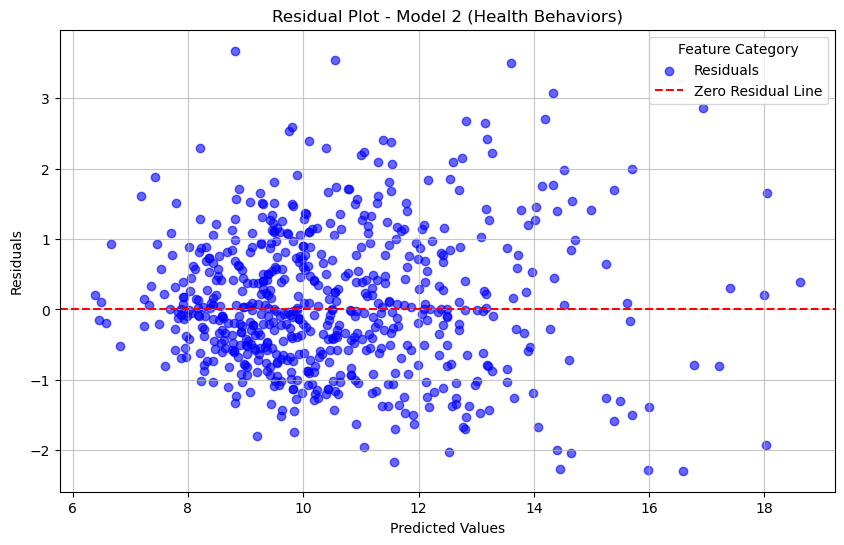

Sample Predictions:
        County        State  % Adults with Diabetes  Predicted  Residual
189     Wilcox      Georgia                    14.7       12.6       2.1
450  Cleveland     Arkansas                    10.9       12.1      -1.2
4       Warren  Mississippi                    13.2       12.1       1.1
425     Cassia        Idaho                    10.7       10.1       0.6
95       Camas        Idaho                     9.6       10.3      -0.7


Residual Analysis and Sample Predictions for Model 3 (Access to Care):


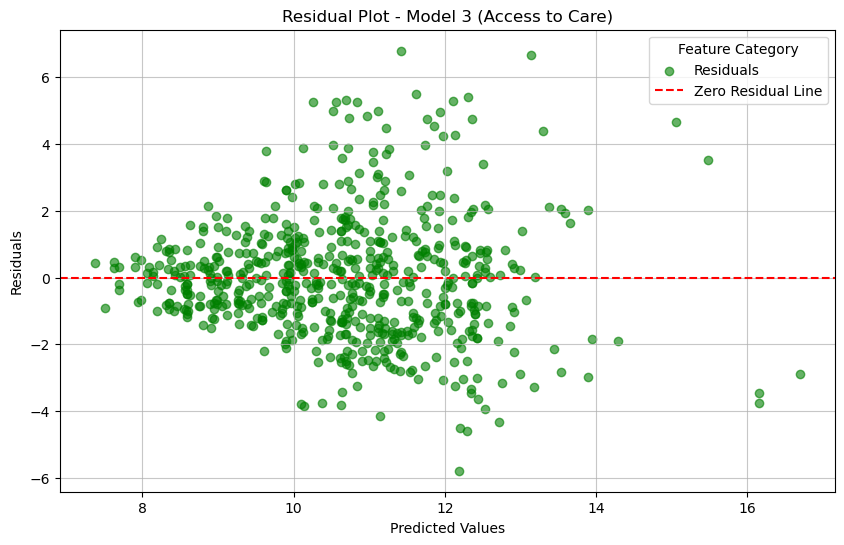

Sample Predictions:
        County      State  % Adults with Diabetes  Predicted  Residual
566  St. Clair   Michigan                     8.9        9.8      -0.9
239    Wyandot       Ohio                     9.7        9.9      -0.2
510      Scott  Minnesota                     7.3        7.7      -0.4
486      Grant   Oklahoma                    10.3       11.6      -1.3
3      Bedford   Virginia                     8.6        8.3       0.3


Residual Analysis and Sample Predictions for Model 4 (Socio-economic Factors):


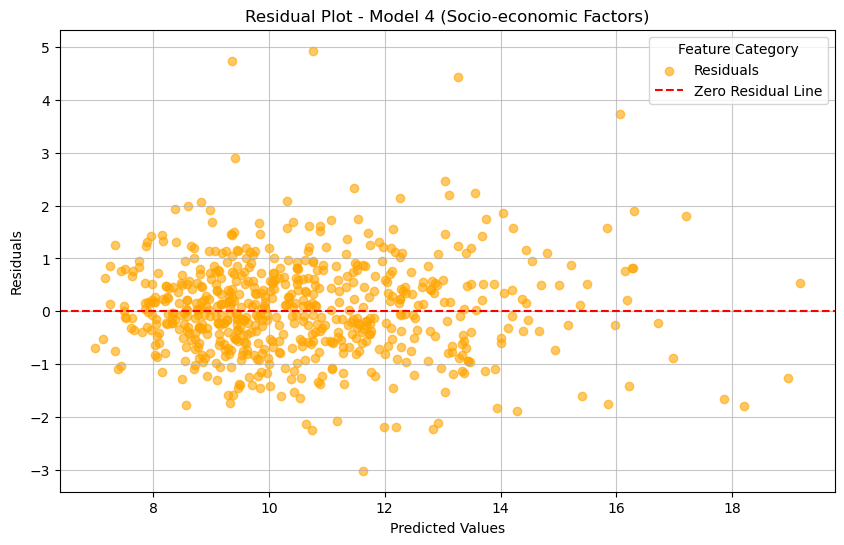

Sample Predictions:
       County       State  % Adults with Diabetes  Predicted  Residual
387  Costilla    Colorado                    12.1       13.9      -1.8
615   Oakland    Michigan                     7.2        8.1      -0.9
139  Crawford   Wisconsin                     8.5        9.2      -0.7
625    Marion     Florida                    10.1       11.3      -1.2
400  Dona Ana  New Mexico                    12.4       12.2       0.2


Residual Analysis and Sample Predictions for Model 5 (Physical Environment):


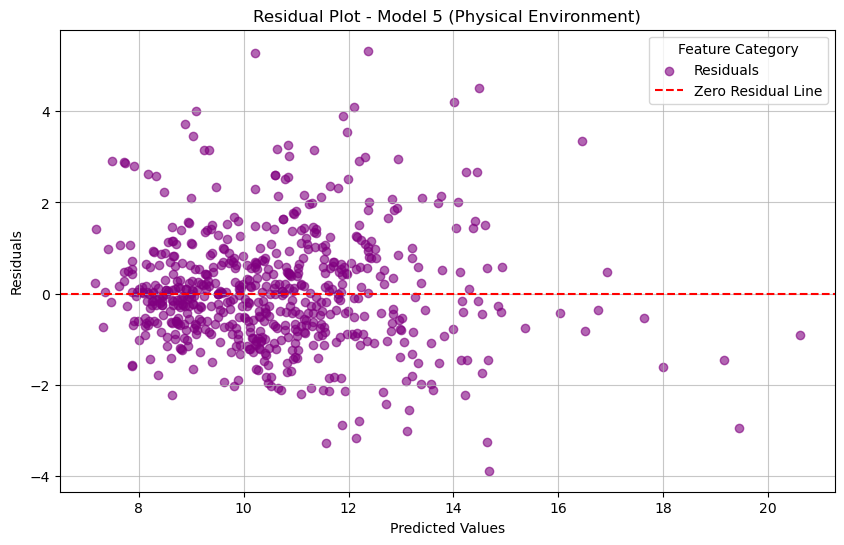

Sample Predictions:
      County           State  % Adults with Diabetes  Predicted  Residual
388   Burnet           Texas                     9.9       10.1      -0.2
596    Pecos           Texas                    15.3       12.3       3.0
307  Belmont            Ohio                    10.9       10.7       0.2
108  Hampton  South Carolina                    15.5       10.2       5.3
230    Floyd        Virginia                     9.1        9.9      -0.8


Residual Analysis and Sample Predictions for Model 6 (Demographics):


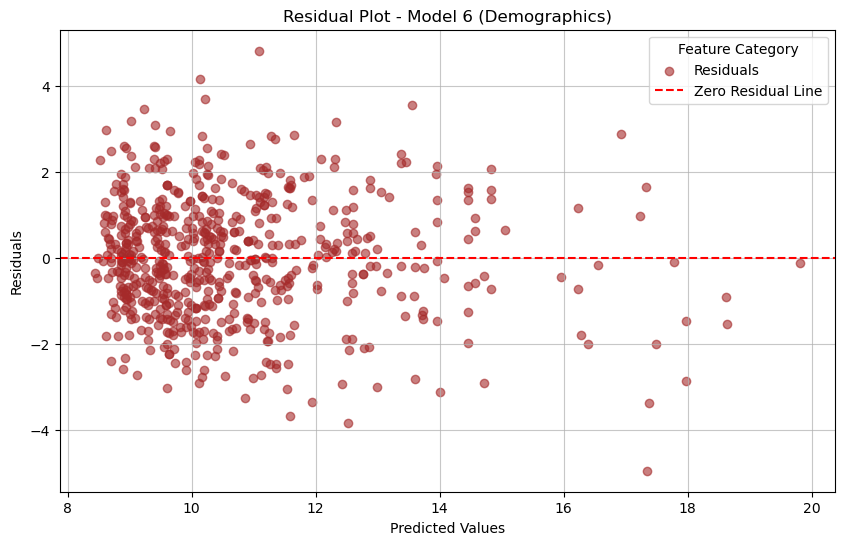

Sample Predictions:
         County         State  % Adults with Diabetes  Predicted  Residual
337     Jerauld  South Dakota                     8.1        8.4      -0.3
437      Loving         Texas                     7.8       10.1      -2.3
81        Butte         Idaho                    10.8        8.5       2.3
575     Warrick       Indiana                     8.7        9.8      -1.1
516  Otter Tail     Minnesota                     8.1        9.8      -1.7




In [27]:
# Plot residuals for each model and show sample predictions
for model_name, model in models.items():
    print(f"Residual Analysis and Sample Predictions for {model_name}:")

    # Match the feature set to the model
    feature_set = {
        "Model 1 (All Features)": all_features,
        "Model 2 (Health Behaviors)": health_behaviors_features,
        "Model 3 (Access to Care)": access_to_care_features,
        "Model 4 (Socio-economic Factors)": socio_economic_features,
        "Model 5 (Physical Environment)": physical_environment_features,
        "Model 6 (Demographics)": demographics_features
    }[model_name]
    
    X_test = test_data[feature_set]
    y_test = test_data[target]

    # Predictions
    y_pred_test = model.predict(X_test)

    # Calculate residuals
    residuals = y_test - y_pred_test

    # Determine the feature category for this model
    feature_category = None
    for category, features in {
        "Health Behaviors": health_behaviors_features,
        "Access to Care": access_to_care_features,
        "Socio-economic Factors": socio_economic_features,
        "Physical Environment": physical_environment_features,
        "Demographics": demographics_features,
        "Other": all_features
    }.items():
        if set(feature_set).issubset(set(features)):
            feature_category = category
            break

    # Use the color matching the feature category
    category_color = category_colors.get(feature_category, "gray")

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_test, residuals, alpha=0.6, label="Residuals", color=category_color)
    plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
    plt.title(f"Residual Plot - {model_name}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.legend(title="Feature Category")
    plt.grid(alpha=0.7)
    plt.show()

    # Display sample predictions for 5 random rows
    random_indices = random.sample(range(len(test_data)), 5)
    sample_data = test_data.iloc[random_indices]
    sample_predictions = model.predict(sample_data[feature_set])

    # Include County, State, and round numbers
    sample_results = sample_data[["County", "State", target]].copy()  # Include 'County' and 'State' columns
    sample_results["Predicted"] = sample_predictions
    sample_results["Residual"] = sample_results[target] - sample_results["Predicted"]
    sample_results = sample_results.round(1)  # Round all numbers to 1 decimal place
    
    print("Sample Predictions:")
    print(sample_results)
    print("\n" + "="*80 + "\n")
